In [59]:
from utils import *
import matplotlib.patches as mpatches

Evaluation compare 

- dist1 (all contigs)
- dist2 (all - problematic SRR)
- dist3 (new fitted curve n=30)
- dist3 (new fitted curve n=60)

In [60]:
df1 = pd.read_csv('../MODEL2/results/snakemake/contig_predictions.csv')
df2 = pd.read_csv('../MODEL3/results/snakemake/contig_predictions.csv')
df3 = pd.read_csv('results/snakemake30/contig_predictions.csv')
df4 = pd.read_csv('results/snakemake60/contig_predictions.csv')

gt = pd.read_excel('/home/tobamo/analize/model-tobamo/notebooks/MODEL3/data/ground_truth_202505230.xlsx')
gt.columns = gt.columns.str.strip()

In [61]:
df1['exp_no'] = 1
df2['exp_no'] = 2
df3['exp_no'] = 3
df4['exp_no'] = 4

df= pd.concat([df1, df2, df3, df4], ignore_index=True)

In [62]:
df['contig_length'] = df['contig_name'].str.extract(r"(?:len_|length_)(\d+)").astype(int)
df['assembler'] = np.where(df['contig_name'].str.startswith('NODE'), 'spades', 'megahit')
df['SRR'] = df["contig_name"].str.extract(r"_([A-Za-z0-9]+)$")
df['problematic_srr'] = df['SRR'] == 'SRR6846476'

In [63]:
merge = pd.merge(gt, df, on='contig_name', how='outer')
merge = merge[merge['problematic_srr'] == False]

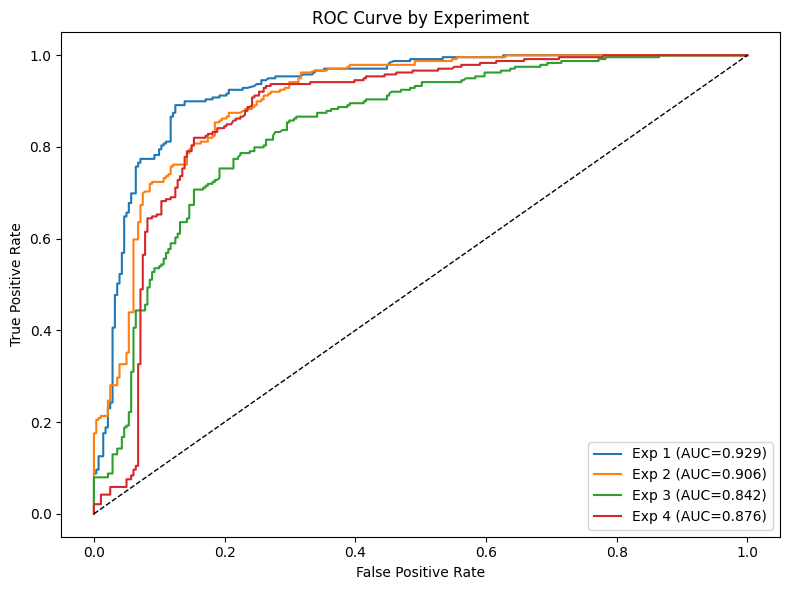

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for exp_no, color in zip(sorted(df['exp_no'].unique()), colors):
    df_exp = merge[merge['exp_no'] == exp_no]
    if 'prob_1' in df_exp.columns:
        y_score = df_exp['prob_1']
    else:
        y_score = df_exp['predicted_class']
    y_true = df_exp['ground_truth']
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color=color, label=f'Exp {exp_no} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Experiment')
plt.legend()
plt.tight_layout()
plt.show()

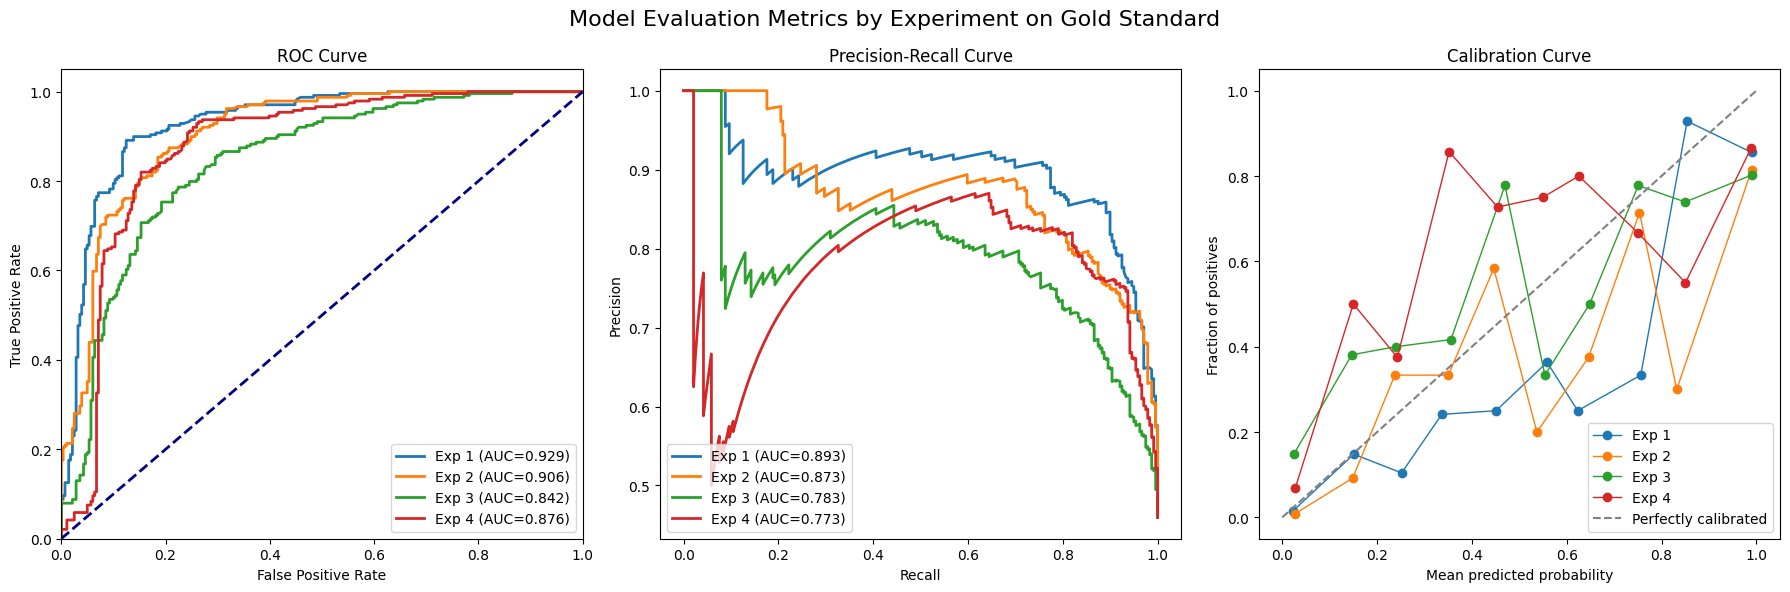

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for exp_no, color in zip(sorted(df['exp_no'].unique()), colors):
    df_exp = merge[merge['exp_no'] == exp_no]
    y_true = df_exp['ground_truth']
    y_score = df_exp['prob_1'] if 'prob_1' in df_exp.columns else df_exp['predicted_class']

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    axes[0].plot(fpr, tpr, color=color, lw=2, label=f'Exp {exp_no} (AUC={roc_auc:.3f})')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, color=color, lw=2, label=f'Exp {exp_no} (AUC={pr_auc:.3f})')

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10)
    axes[2].plot(prob_pred, prob_true, marker='o', color=color, lw=1, label=f'Exp {exp_no}')

# ROC Curve formatting
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Precision-Recall formatting
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")

# Calibration Curve formatting
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
axes[2].set_xlabel('Mean predicted probability')
axes[2].set_ylabel('Fraction of positives')
axes[2].set_title('Calibration Curve')
axes[2].legend(loc="lower right")

plt.suptitle('Model Evaluation Metrics by Experiment on Gold Standard', fontsize=16)
plt.tight_layout()
plt.show()

In [66]:
merge['correct'] = merge['ground_truth'] == merge['predicted_class']

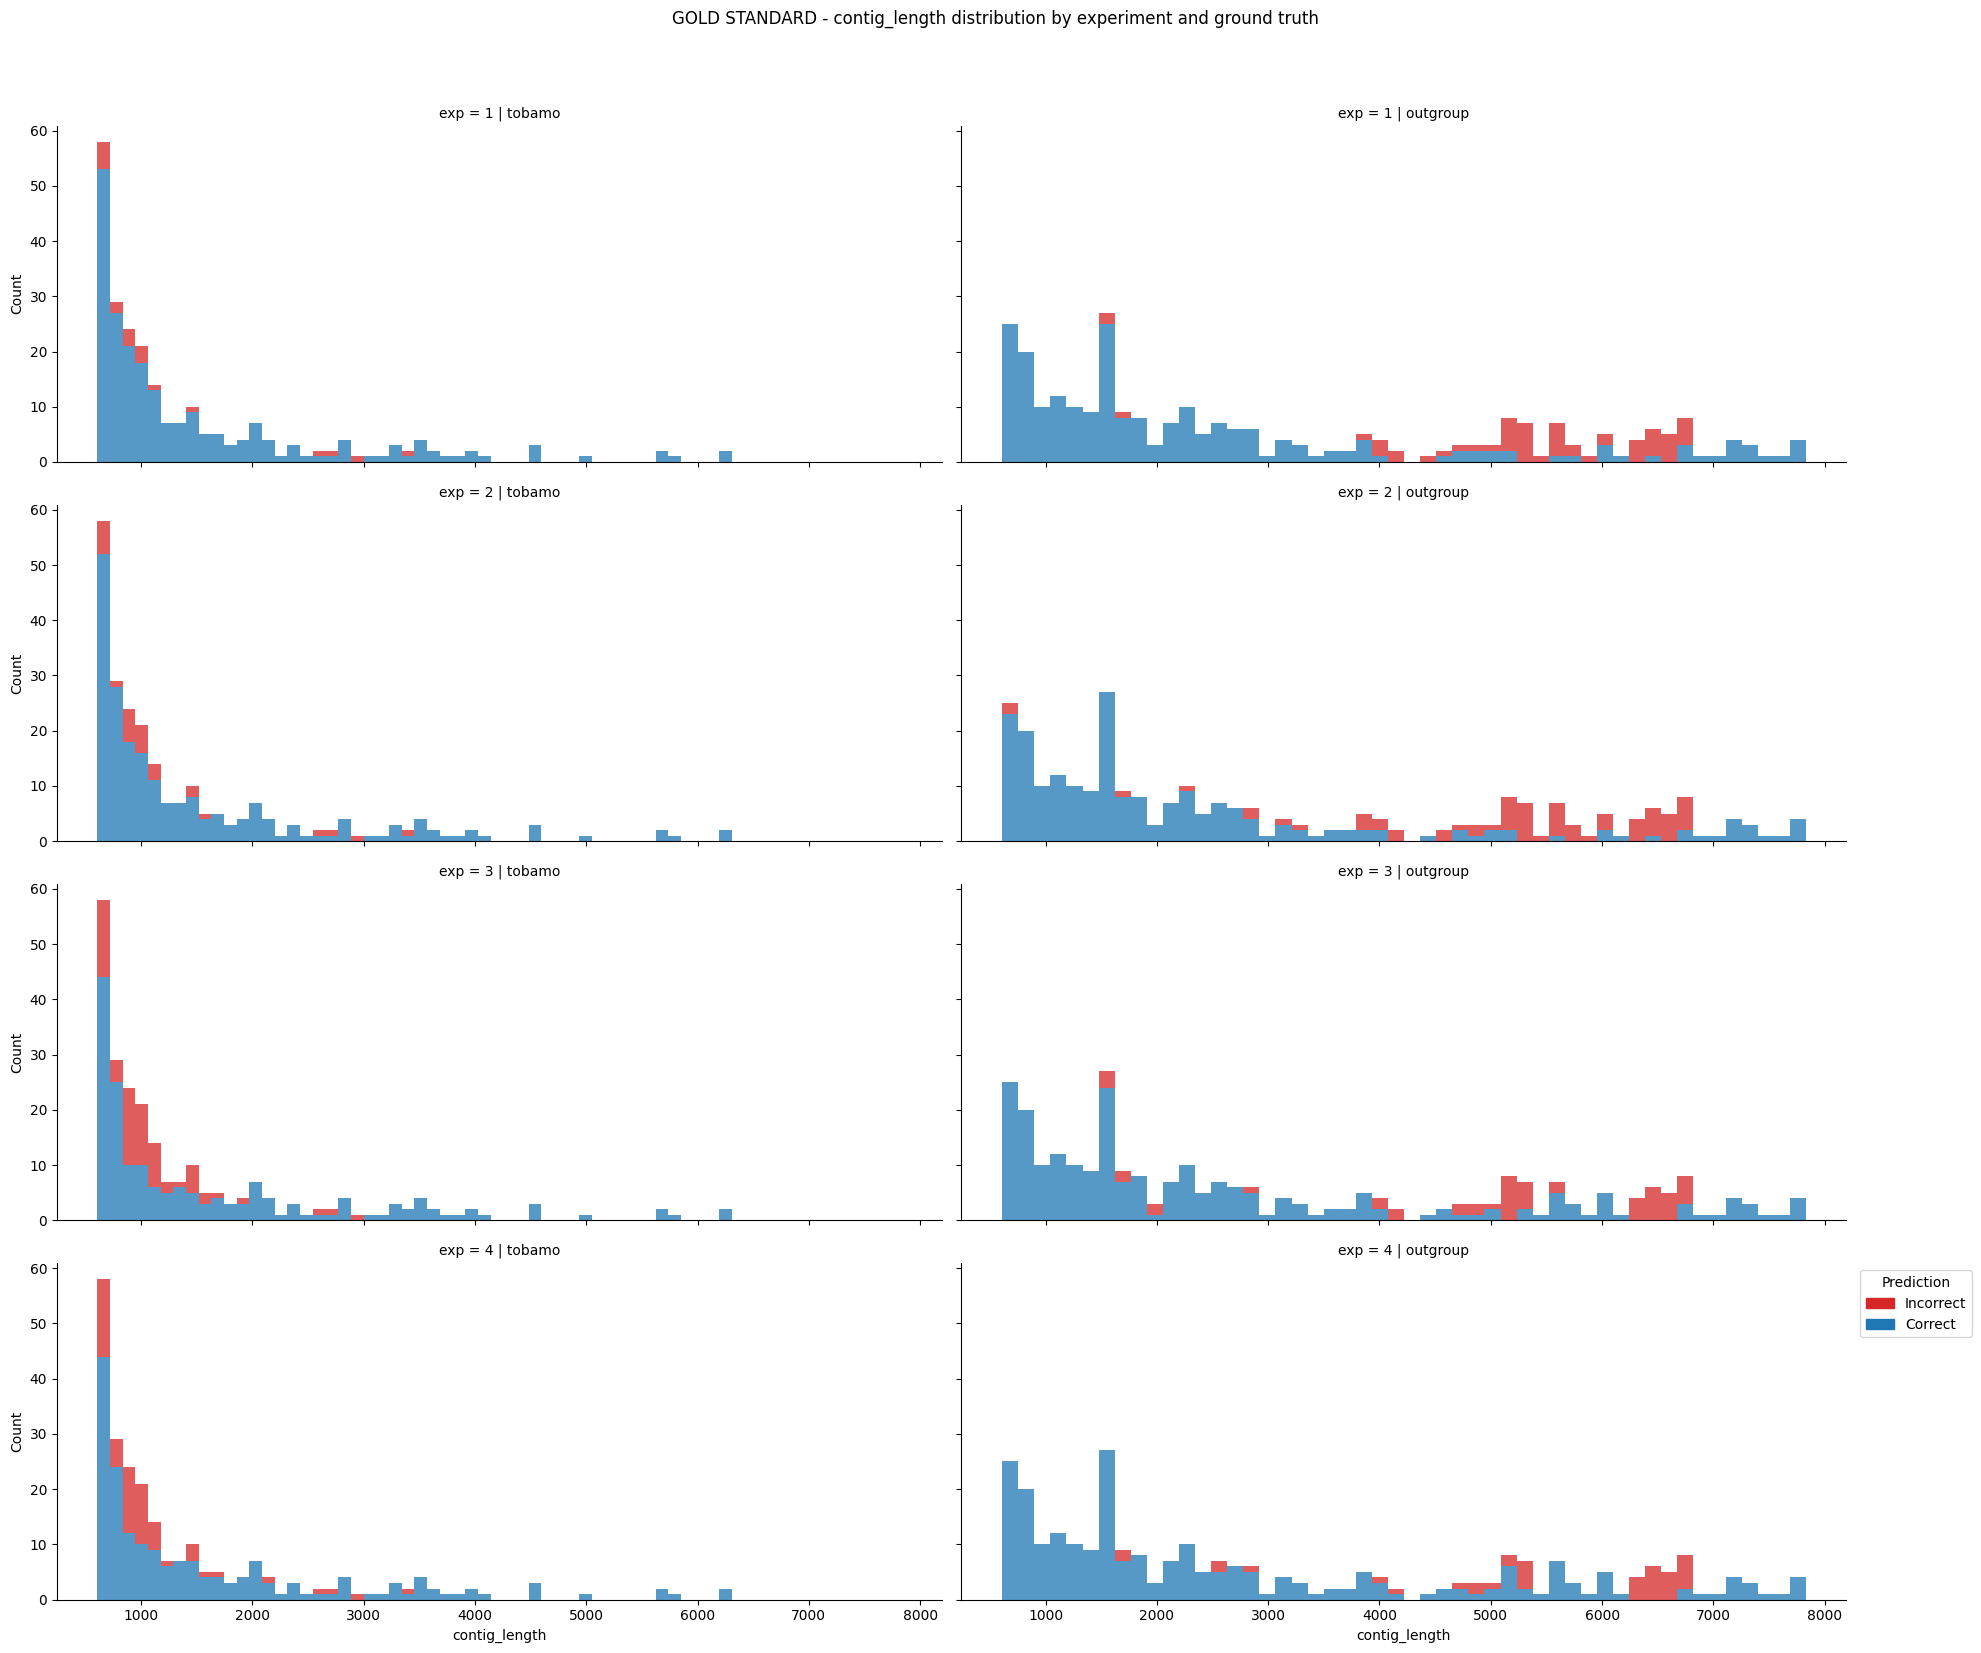

In [67]:
# Map ground_truth values to labels
col_labels = {0.0: 'outgroup', 1.0: 'tobamo'}
merge['ground_truth_label'] = merge['ground_truth'].map(col_labels)

g = sns.FacetGrid(
    merge,
    row="exp_no",
    col="ground_truth_label",
    height=4,
    aspect=2.5,
    sharey=True,
    margin_titles=False
)
g.map_dataframe(
    sns.histplot,
    x="contig_length",
    hue="correct",
    bins=50,
    multiple="stack",
    palette={0: "tab:red", 1: "tab:blue"},
    edgecolor=None
)
g.set_axis_labels("contig_length", "Count")
g.set_titles(row_template="exp = {row_name}", col_template="{col_name}")

g.fig.subplots_adjust(wspace=0.05, hspace=0.15)

handles = [
    mpatches.Patch(color='tab:red', label='Incorrect'),
    mpatches.Patch(color='tab:blue', label='Correct')
]
plt.legend(handles=handles, title="Prediction", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.suptitle("GOLD STANDARD - contig_length distribution by experiment and ground truth", y=1.03)
plt.tight_layout()
plt.show()

In [68]:
merge = merge[merge['correct'] == False]

In [69]:
merge.category.value_counts()

category
3.0    119
5.0     91
2.0     87
8.0     61
1.0     23
7.0      4
6.0      3
Name: count, dtype: int64

/tmp/ipykernel_3656492/2640851602.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge['ground_truth_label'] = merge['ground_truth'].map(col_labels)


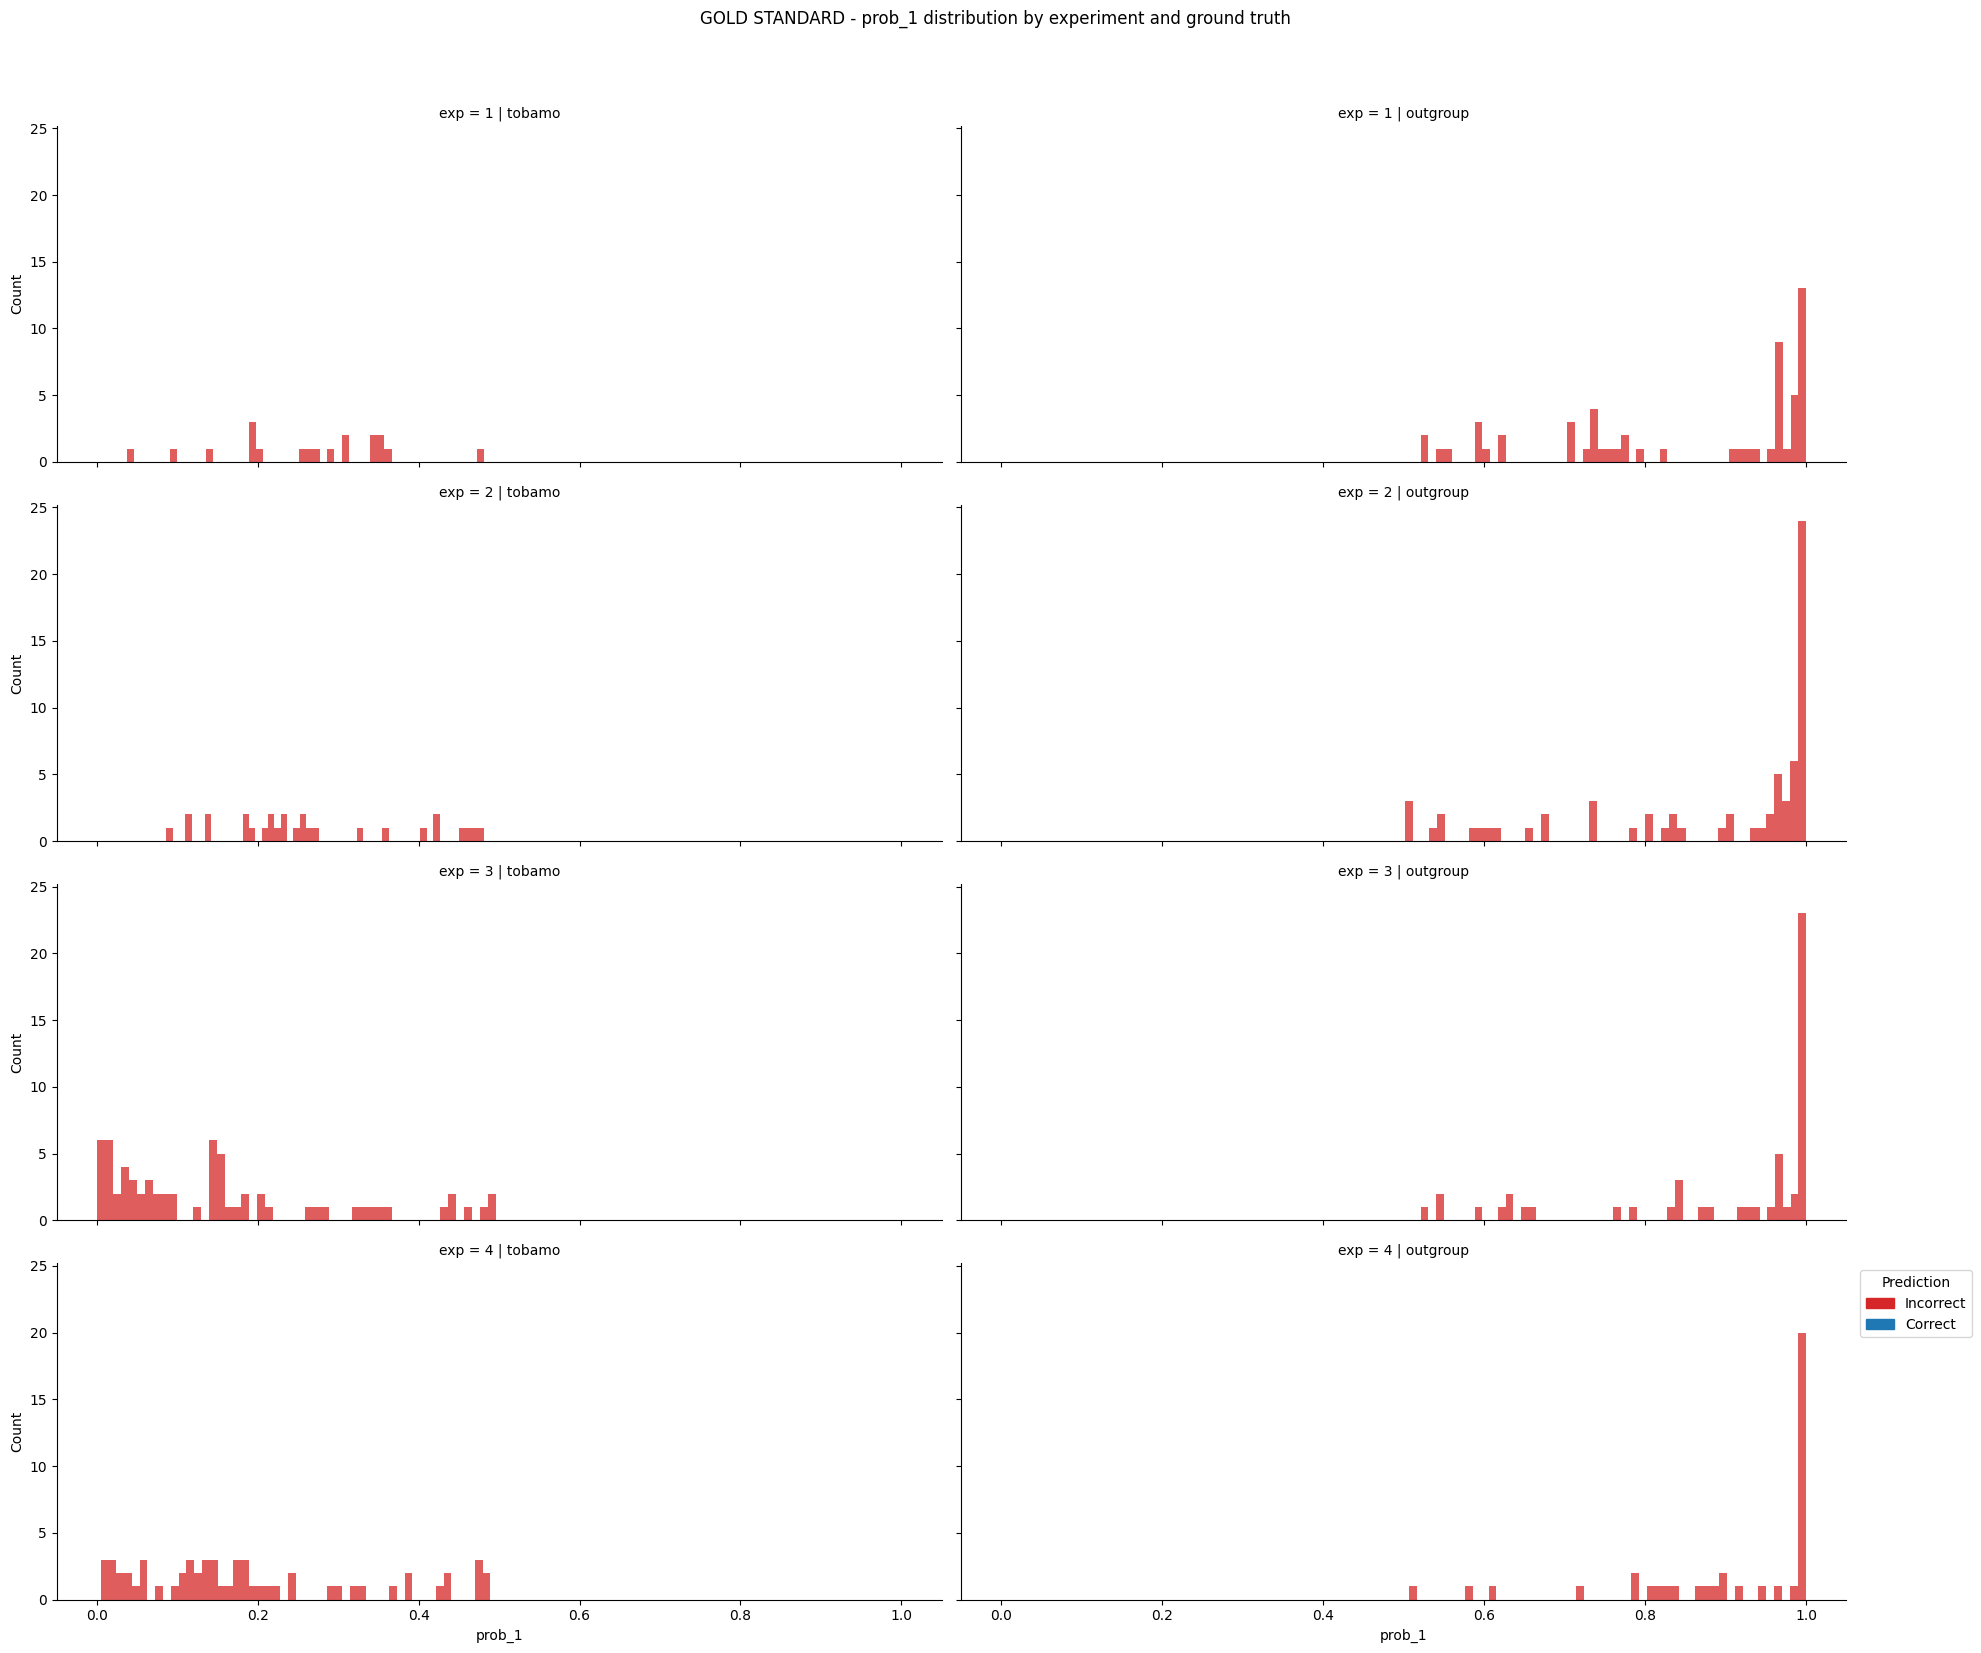

In [70]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

# Map ground_truth values to labels
col_labels = {0.0: 'outgroup', 1.0: 'tobamo'}
merge['ground_truth_label'] = merge['ground_truth'].map(col_labels)

g = sns.FacetGrid(
    merge,
    row="exp_no",
    col="ground_truth_label",
    height=4,
    aspect=2.5,
    sharey=True,
    margin_titles=False
)
g.map_dataframe(
    sns.histplot,
    x="prob_1",
    hue="correct",
    bins=50,
    multiple="stack",
    palette={0: "tab:red", 1: "tab:blue"},
    edgecolor=None
)
g.set_axis_labels("prob_1", "Count")
g.set_titles(row_template="exp = {row_name}", col_template="{col_name}")

g.fig.subplots_adjust(wspace=0.05, hspace=0.15)

handles = [
    mpatches.Patch(color='tab:red', label='Incorrect'),
    mpatches.Patch(color='tab:blue', label='Correct')
]
plt.legend(handles=handles, title="Prediction", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.suptitle("GOLD STANDARD - prob_1 distribution by experiment and ground truth", y=1.03)
plt.tight_layout()
plt.show()

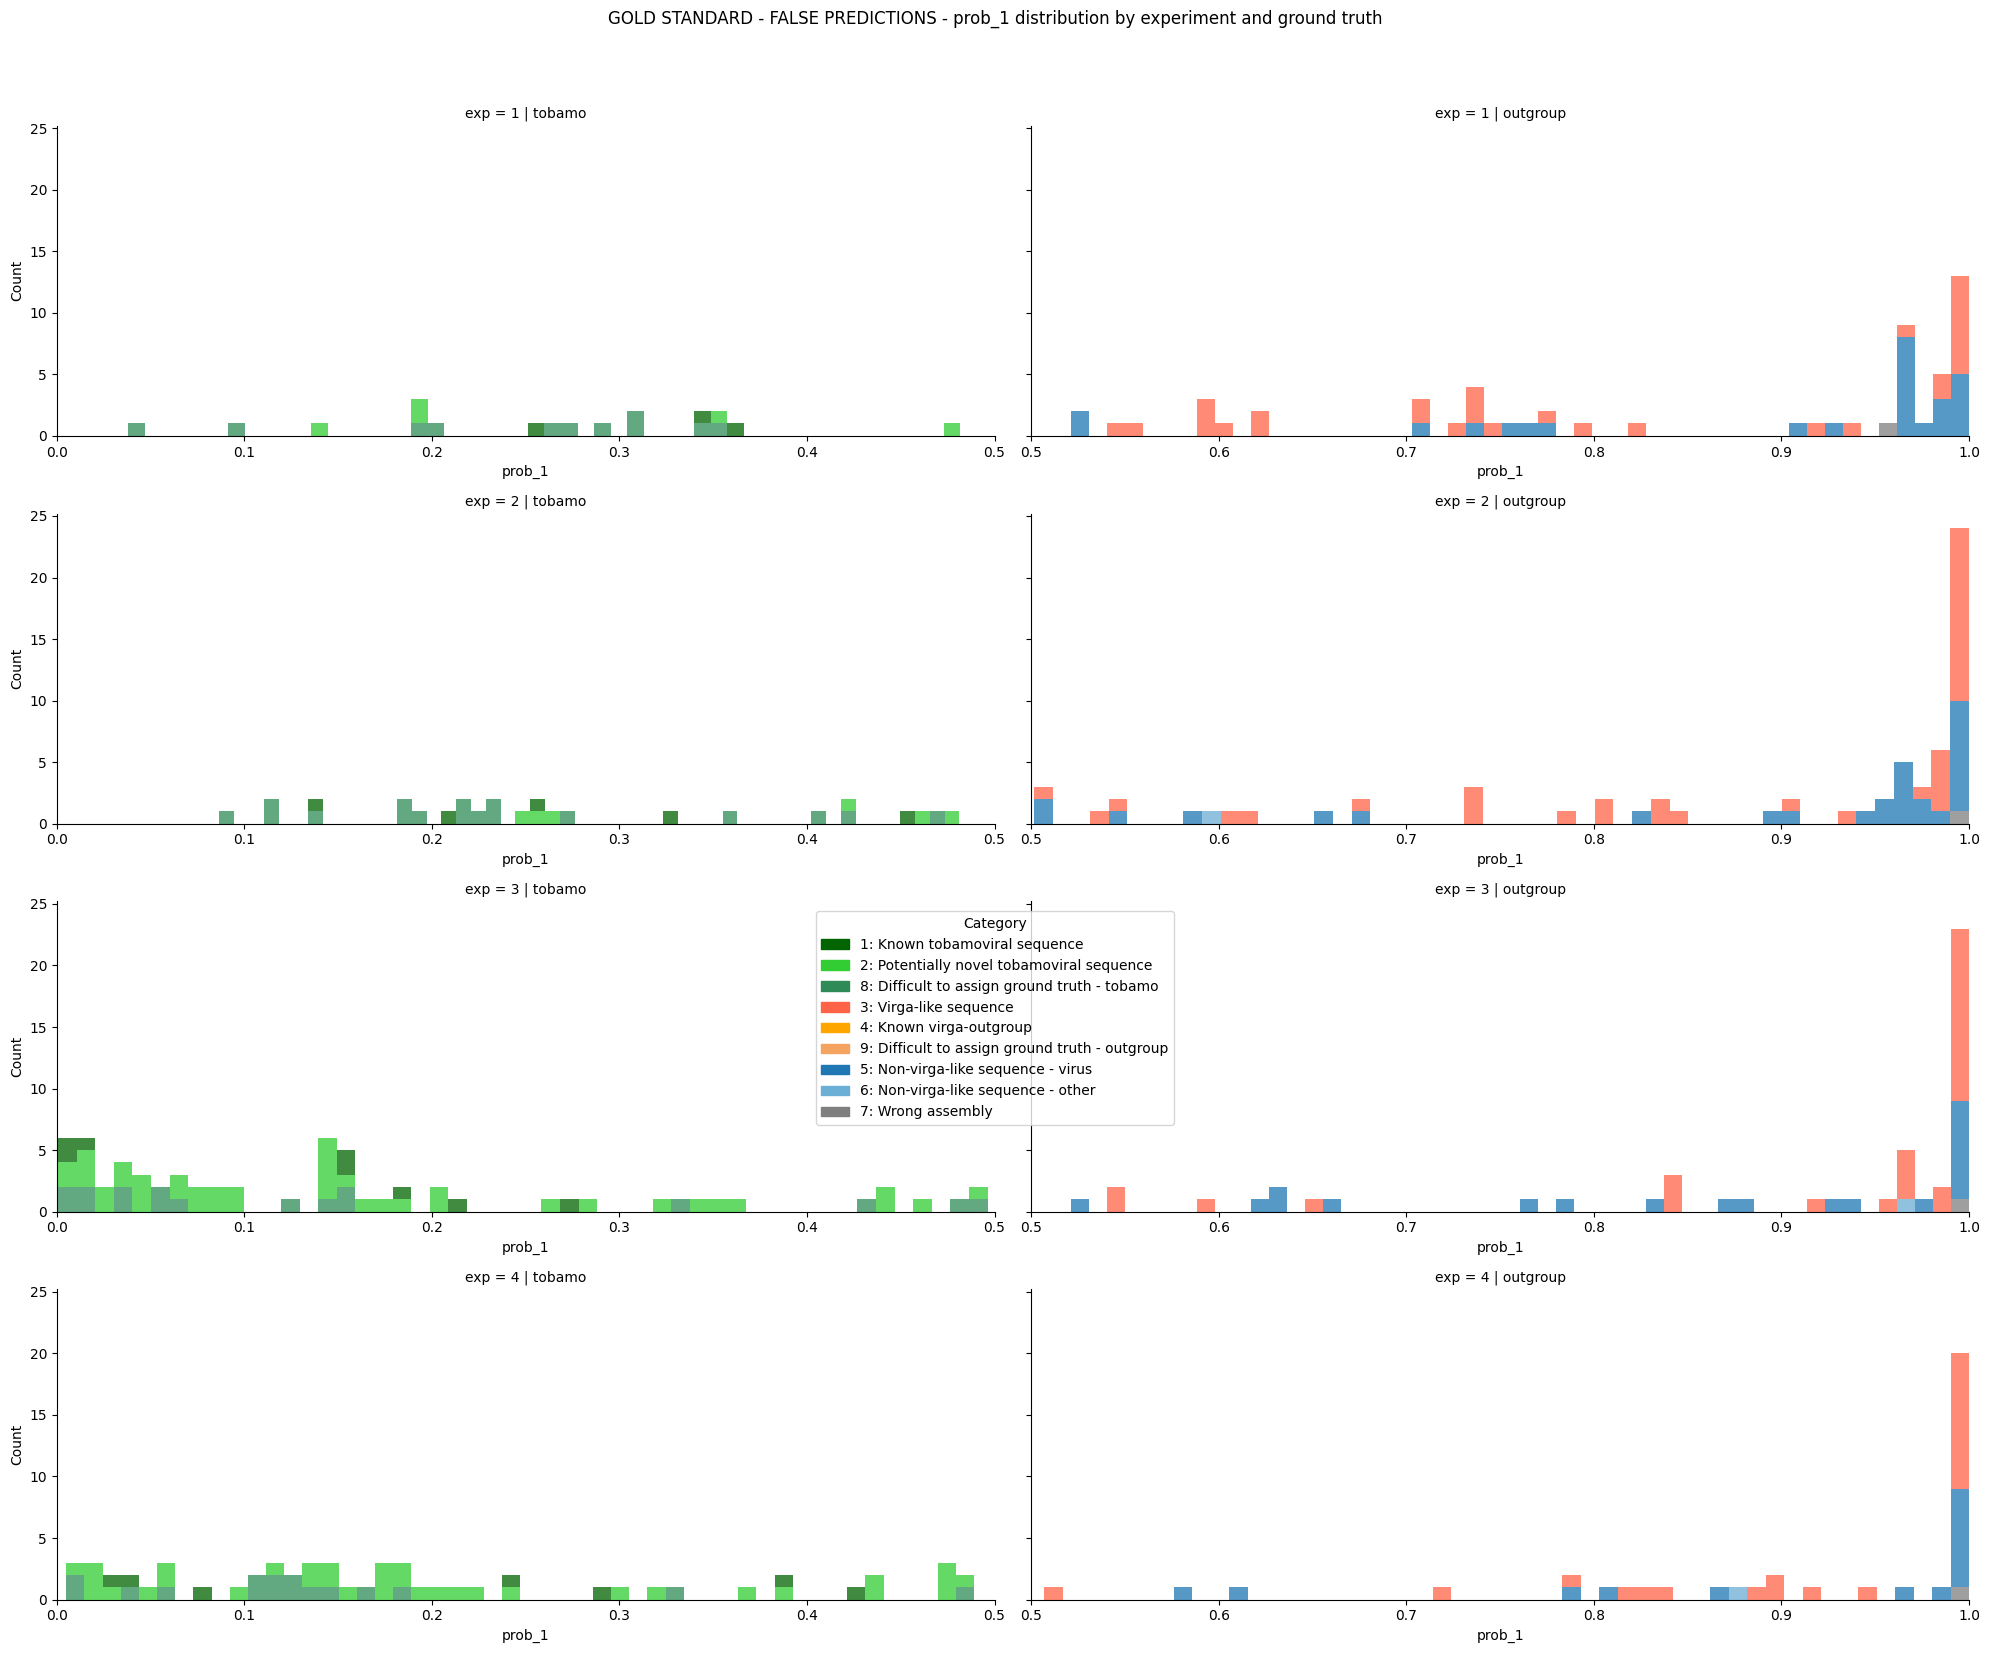

In [82]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

category_map = {
    1: "Known tobamoviral sequence",
    2: "Potentially novel tobamoviral sequence",
    3: "Virga-like sequence",
    4: "Known virga-outgroup",
    5: "Non-virga-like sequence - virus",
    6: "Non-virga-like sequence - other",
    7: "Wrong assembly",
    8: "Difficult to assign ground truth - tobamo",
    9: "Difficult to assign ground truth - outgroup"
}

category_palette = {
    1: "#006400",   # dark green
    2: "#32CD32",   # lime green
    8: "#2E8B57",   # sea green
    3: "#FF6347",   # tomato
    4: "#FFA500",   # orange
    9: "#F4A460",   # sandy brown
    5: "#1f77b4",   # blue
    6: "#6baed6",   # light blue
    7: "#7f7f7f",   # grey
}

g = sns.FacetGrid(
    merge,
    row="exp_no",
    col="ground_truth_label",
    height=4,
    aspect=2.5,
    sharey=True,
    sharex=False,  # <-- Allow independent x-axes!
    margin_titles=False
)
g.map_dataframe(
    sns.histplot,
    x="prob_1",
    hue="category",
    bins=50,
    multiple="stack",
    palette=category_palette,
    edgecolor=None
)
g.set_axis_labels("prob_1", "Count")
g.set_titles(row_template="exp = {row_name}", col_template="{col_name}")

g.fig.subplots_adjust(wspace=0.05, hspace=0.15)

# Set xlim and x-ticks for each subplot independently
for row_idx in range(len(g.row_names)):
    for col_idx, col_val in enumerate(g.col_names):
        ax = g.axes[row_idx, col_idx]
        if col_val == 'tobamo':
            ax.set_xlim(0, 0.5)
            ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
        elif col_val == 'outgroup':
            ax.set_xlim(0.5, 1)
            ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.set_xlabel("prob_1")  # Set x-label for all

# Custom legend for categories with descriptive names
handles = [
    mpatches.Patch(color=category_palette[cat], label=f'{cat}: {category_map[cat]}')
    for cat in category_palette
]
g.fig.legend(
    handles=handles,
    title="Category",
    loc='center',
    bbox_to_anchor=(0.5, 0.4),
    frameon=True,
    ncol=1
)

plt.suptitle("GOLD STANDARD - FALSE PREDICTIONS - prob_1 distribution by experiment and ground truth", y=1.03)
plt.tight_layout()
plt.show()

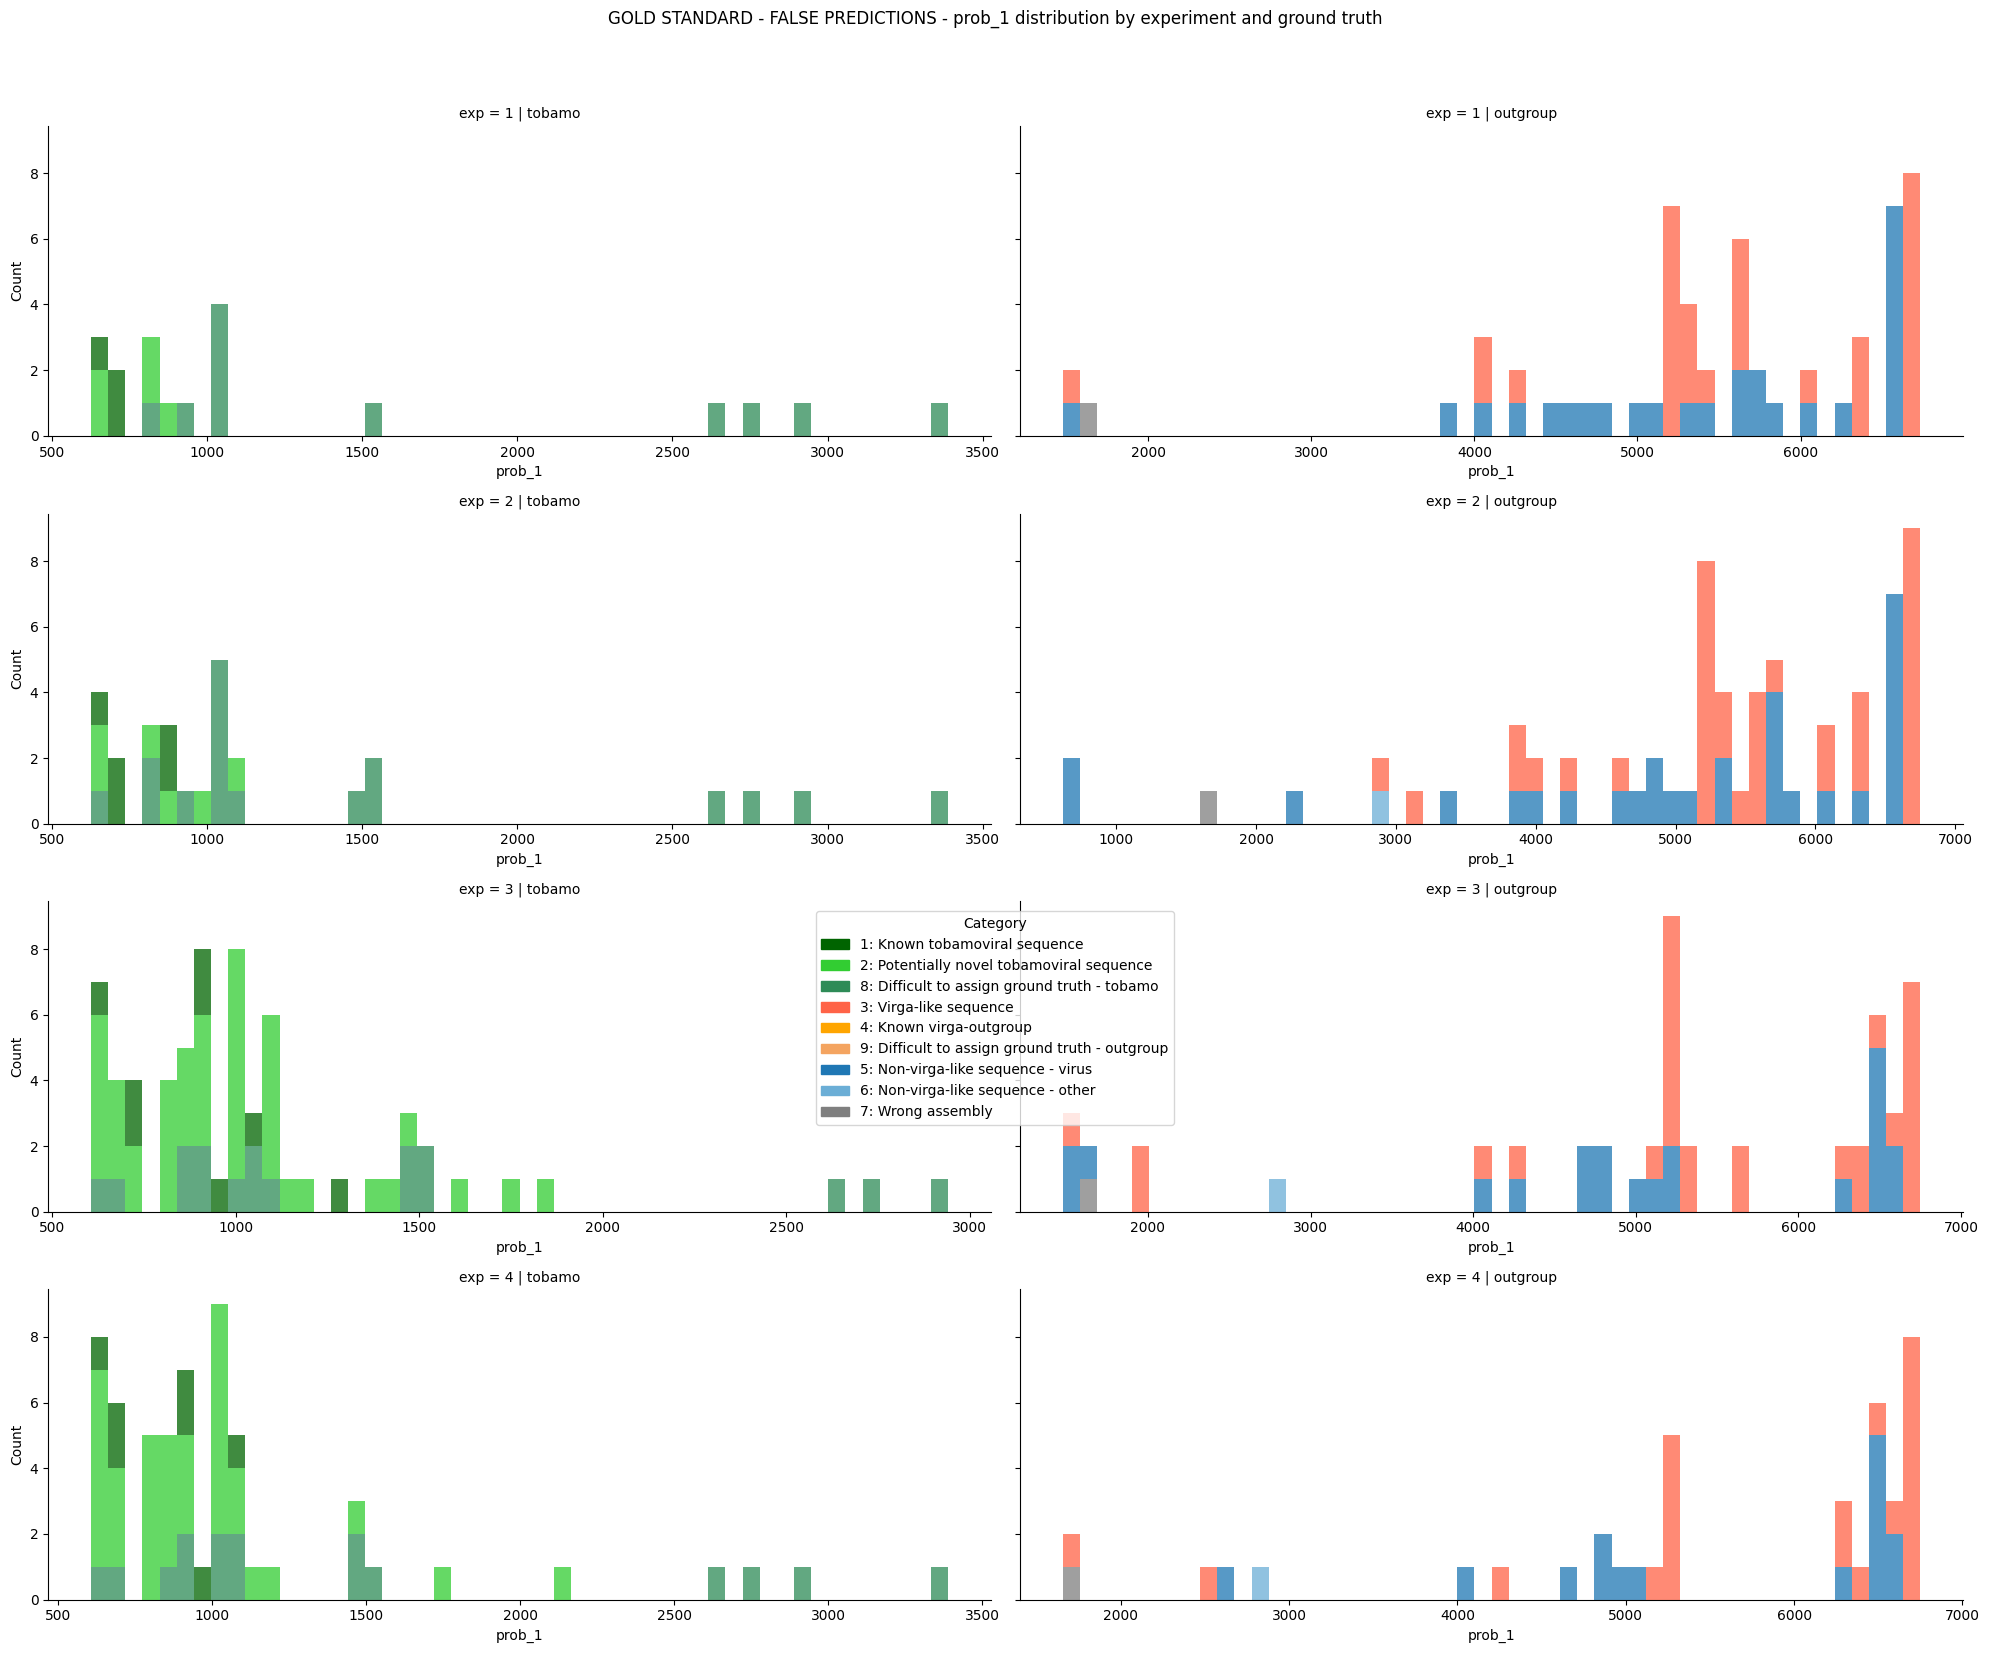

In [84]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

category_map = {
    1: "Known tobamoviral sequence",
    2: "Potentially novel tobamoviral sequence",
    3: "Virga-like sequence",
    4: "Known virga-outgroup",
    5: "Non-virga-like sequence - virus",
    6: "Non-virga-like sequence - other",
    7: "Wrong assembly",
    8: "Difficult to assign ground truth - tobamo",
    9: "Difficult to assign ground truth - outgroup"
}

category_palette = {
    1: "#006400",   # dark green
    2: "#32CD32",   # lime green
    8: "#2E8B57",   # sea green
    3: "#FF6347",   # tomato
    4: "#FFA500",   # orange
    9: "#F4A460",   # sandy brown
    5: "#1f77b4",   # blue
    6: "#6baed6",   # light blue
    7: "#7f7f7f",   # grey
}

g = sns.FacetGrid(
    merge,
    row="exp_no",
    col="ground_truth_label",
    height=4,
    aspect=2.5,
    sharey=True,
    sharex=False,  # <-- Allow independent x-axes!
    margin_titles=False
)
g.map_dataframe(
    sns.histplot,
    x="contig_length",
    hue="category",
    bins=50,
    multiple="stack",
    palette=category_palette,
    edgecolor=None
)
g.set_axis_labels("prob_1", "Count")
g.set_titles(row_template="exp = {row_name}", col_template="{col_name}")

g.fig.subplots_adjust(wspace=0.05, hspace=0.15)

# Set xlim and x-ticks for each subplot independently
for row_idx in range(len(g.row_names)):
    for col_idx, col_val in enumerate(g.col_names):
        ax = g.axes[row_idx, col_idx]
        # if col_val == 'tobamo':
        #     ax.set_xlim(0, 0.5)
        #     ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
        # elif col_val == 'outgroup':
        #     ax.set_xlim(0.5, 1)
        #     ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.set_xlabel("prob_1")  # Set x-label for all

# Custom legend for categories with descriptive names
handles = [
    mpatches.Patch(color=category_palette[cat], label=f'{cat}: {category_map[cat]}')
    for cat in category_palette
]
g.fig.legend(
    handles=handles,
    title="Category",
    loc='center',
    bbox_to_anchor=(0.5, 0.4),
    frameon=True,
    ncol=1
)

plt.suptitle("GOLD STANDARD - FALSE PREDICTIONS - prob_1 distribution by experiment and ground truth", y=1.03)
plt.tight_layout()
plt.show()

In [72]:
for col_idx, col_val in enumerate(g.col_names):
    print(f"Column: '{col_val}'")

Column: 'tobamo'
Column: 'outgroup'


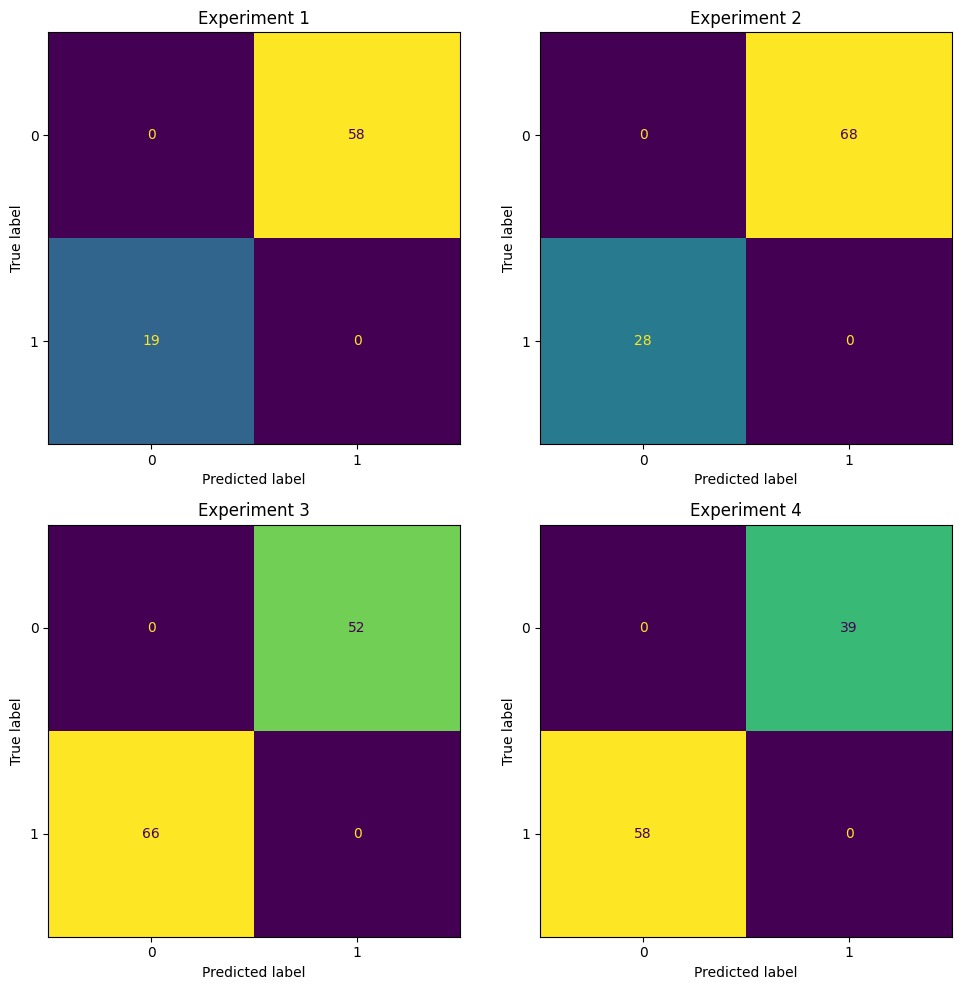

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

exp_nos = sorted(merge['exp_no'].unique())
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, exp_no in enumerate(exp_nos):
    df_exp = merge[merge['exp_no'] == exp_no]
    y_true = df_exp['ground_truth']
    y_pred = df_exp['predicted_class']
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = axs[i // 2, i % 2]
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f'Experiment {exp_no}')

plt.tight_layout()
plt.show()

Distribucija tobamo pri gold standardu

/tmp/ipykernel_3656492/3509357651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tobamo['contig_length'] = tobamo['contig_name'].str.extract(r"(?:len_|length_)(\d+)").astype(int)


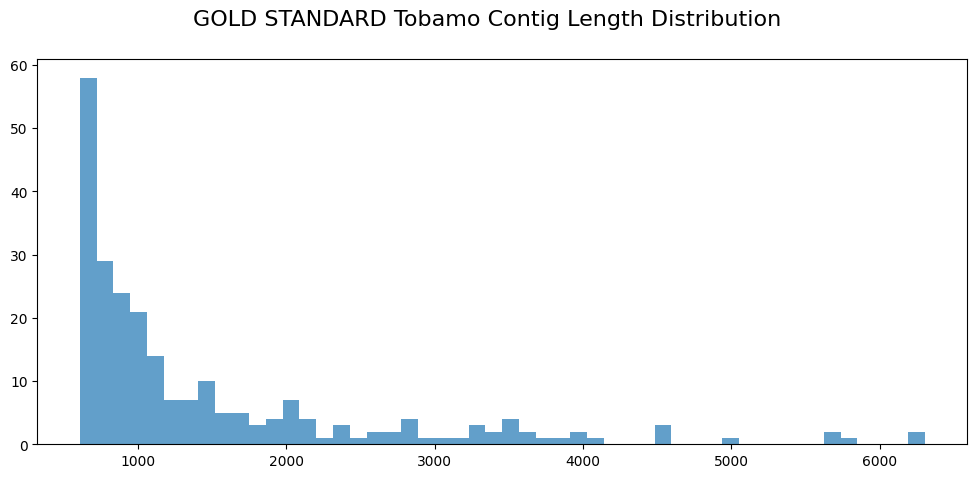

In [74]:
tobamo = gt.loc[gt['ground_truth'] == 1.0]

tobamo['contig_length'] = tobamo['contig_name'].str.extract(r"(?:len_|length_)(\d+)").astype(int)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))

plt.hist(tobamo['contig_length'], bins=50, color='tab:blue', alpha=0.7)
plt.suptitle('GOLD STANDARD Tobamo Contig Length Distribution', fontsize=16)
plt.show()

In [75]:
new_sample = tobamo['contig_length'].to_list()

In [76]:
from scipy.optimize import curve_fit

In [77]:
lens_freq = mpu.io.read('results/training/sampling/fitted_curve_lens_freq.json')
xfine = [float(k) for k in lens_freq.keys()]
y_fitted = [lens_freq[k] for k in lens_freq.keys()]

[625.00333333 663.01       701.01666667] [0.00198159 0.00231186 0.00209168]
[ 1.90505199e-02  3.59217797e-03 -2.82682505e-08  1.67711719e-04]


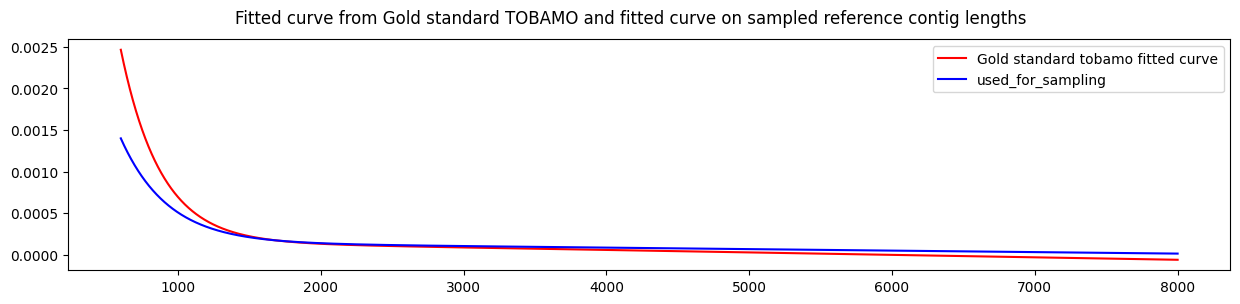

In [78]:
# bin the data
bins = 150
ydata, bin_edges = np.histogram(new_sample, bins=bins, density=True)
xdata = 0.5 * (bin_edges[1:] + bin_edges[:-1])
print(xdata[:3], ydata[:3])

# fit function to binned data
def func2(x, a, b, c, d):
    return a * np.exp(-b * x) + c*x + d

p0 = [7.93139545e-03, 3.05621468e-03, -1.81668155e-08, 1.58731686e-04]  # initial guess for parameters
popt, pcov = curve_fit(func2, xdata, ydata, p0=p0, maxfev=10000)
print(popt)

# fit to needed range
xfine = range(600, 8000+1)
sample_y_fitted = func2(xfine, *popt)  # popt[0], popt[1], popt[2])
# make sure it sums to 1.0
sample_y_fitted /= sum(sample_y_fitted)

# plot the data
plt.figure(figsize=(15, 3))

# plot the fitted function
plt.plot(xfine, sample_y_fitted, 'r-', label='Gold standard tobamo fitted curve')
plt.plot(xfine, y_fitted, 'b-', label='used_for_sampling')
plt.suptitle('Fitted curve from Gold standard TOBAMO and fitted curve on sampled reference contig lengths')
plt.legend()
plt.show()

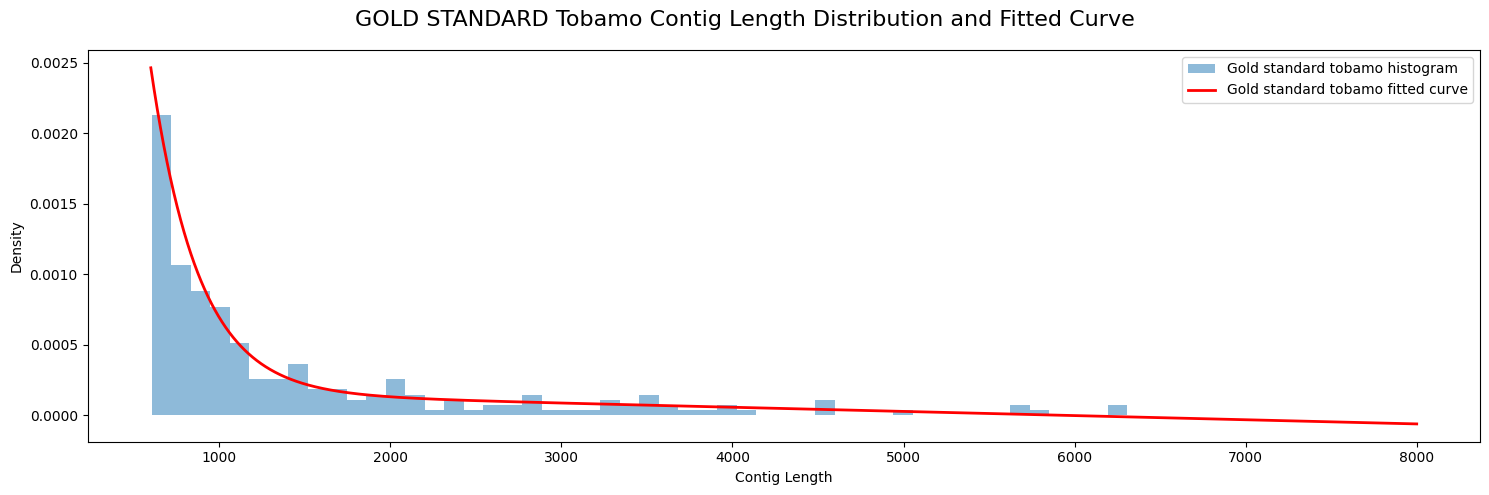

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract contig lengths from gold standard tobamo
tobamo = gt.loc[gt['ground_truth'] == 1.0].copy()
tobamo['contig_length'] = tobamo['contig_name'].str.extract(r"(?:len_|length_)(\d+)").astype(int)

# Bin the data
bins = 150
new_sample = tobamo['contig_length'].values
ydata, bin_edges = np.histogram(new_sample, bins=bins, density=True)
xdata = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Fit function to binned data
def func2(x, a, b, c, d):
    return a * np.exp(-b * x) + c * x + d

p0 = [7.93139545e-03, 3.05621468e-03, -1.81668155e-08, 1.58731686e-04]  # initial guess for parameters
popt, pcov = curve_fit(func2, xdata, ydata, p0=p0, maxfev=10000)

# Fit to needed range
xfine = np.arange(600, 8001)
sample_y_fitted = func2(xfine, *popt)
sample_y_fitted /= sample_y_fitted.sum()  # Normalize to sum to 1.0

# If you have y_fitted from a previous fit, load it here (optional)
# Example: y_fitted = ... (should be same length as xfine)
# plt.plot(xfine, y_fitted, 'b-', label='used_for_sampling')

# Plot histogram and fitted curve
fig, ax = plt.subplots(figsize=(15, 5))

# Plot histogram of gold standard contig lengths
ax.hist(tobamo['contig_length'], bins=50, color='tab:blue', alpha=0.5, density=True, label='Gold standard tobamo histogram')

# Plot the fitted function
ax.plot(xfine, sample_y_fitted, 'r-', label='Gold standard tobamo fitted curve', linewidth=2)

# If you have y_fitted, plot it as well
# ax.plot(xfine, y_fitted, 'b-', label='used_for_sampling', linewidth=2)

plt.suptitle('GOLD STANDARD Tobamo Contig Length Distribution and Fitted Curve', fontsize=16)
plt.xlabel('Contig Length')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

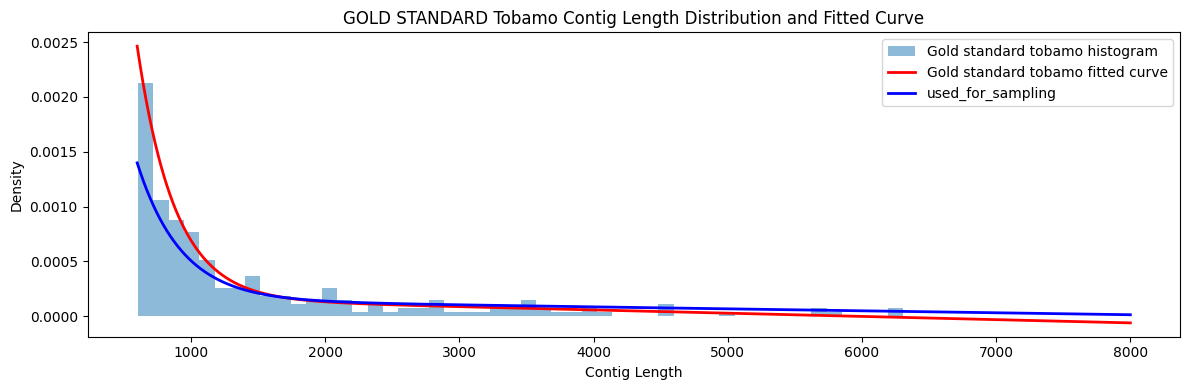

In [80]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

ax.hist(tobamo['contig_length'], bins=50, color='tab:blue', alpha=0.5, density=True, label='Gold standard tobamo histogram')
ax.plot(xfine, sample_y_fitted, 'r-', label='Gold standard tobamo fitted curve', linewidth=2)
# If you have y_fitted, plot it as well
ax.plot(xfine, y_fitted, 'b-', label='used_for_sampling', linewidth=2)
ax.set_title('GOLD STANDARD Tobamo Contig Length Distribution and Fitted Curve')
ax.set_xlabel('Contig Length')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()